In [35]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from unet import Unet
import os
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

torch.manual_seed(0)

In [36]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''
    
    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )
    
    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [37]:
class MNISTDiffusion(nn.Module):
    def __init__(self, image_size, in_channels, time_embedding_dim = 256, timesteps = 4000, base_dim = 32, dim_mults = [1, 2, 4, 8], device = "cuda"):
        super().__init__()
        self.in_channels = in_channels
        self.timesteps = timesteps
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)
        self.register_buffer("betas", betas)
        alphas = 1. - betas
        self.register_buffer("alphas", alphas)
        alphas_cumprod = alphas.cumprod(dim=-1)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", sqrt_alphas_cumprod)
        gamma = 1 - alphas_cumprod
        sqrt_gamma = torch.sqrt(gamma)
        self.register_buffer("sqrt_gamma", sqrt_gamma)
        self.model = Unet(timesteps, time_embedding_dim, in_channels, in_channels, base_dim, dim_mults)
      
    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5) ** 2
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)
        return betas

    def forward(self, x, noise):
        # t = torch.randint(0, self.timesteps, size=(x.size(0),), device=x.device)
        # t = t.to(torch.long)  
        # t_tensor = t.unsqueeze(1)

        b_size = x.shape[0]
        t = torch.randint(0,self.timesteps, (b_size,), device = x.device)
        x_t = self._forward_diffusion(x, t, noise)
        epsilon = self.model(x_t, t)
        pred_noise = epsilon 
        return pred_noise
        
    def _forward_diffusion(self,x_0,t,noise):
        # alpha_t = 1 - self.beta_schedule[t]

        alphas_cumprod = self.alphas_cumprod.to(x_0.device)
        mean = self.sqrt_alphas_cumprod[t][:,None, None, None]*x_0
        std = self.sqrt_gamma[t][:,None, None, None]
        x_t = mean + std*noise
        noisy_sample = x_t
        # alpha_t_sqrt = torch.sqrt(alpha_t)
        # one_minus_alpha_t_sqrt = torch.sqrt(1 - alpha_t)
        # noisy_sample = x_0 * alpha_t_sqrt[:, None, None, None] + noise * one_minus_alpha_t_sqrt[:, None, None, None]       
        return noisy_sample

    @torch.no_grad()
    def _reverse_diffusion(self, x_t, t, noise):#, reversed_beta_schedule):
        epsilon = self.model(x_t, t)

        # alphas_t = self.alphas[t][:,None, None, None]
        # alphas_cumprod_t = self.alphas_cumprod[t][:,None,None,None]
        # betas_t = self.betas[t][:,None, None, None]
        x0_pred = torch.sqrt(1. / self.alphas_cumprod[t][:,None, None, None])*x_t - torch.sqrt(1. / self.alphas_cumprod[t][:,None,None,None] - 1.)* epsilon
        x0_pred.clamp_(-1.,1.)
        if t.min() > 0:
            alphas_cumprod_prev = self.alphas_cumprod[t-1][:,None,None,None]
            mean = (self.betas[t][:,None,None,None]* torch.sqrt(alphas_cumprod_prev)/(1. - self.alphas_cumprod[t][:,None,None,None]))*x0_pred + ((1. - alphas_cumprod_prev)*torch.sqrt(self.alphas[t][:,None,None,None])/ (1. - self.alphas_cumprod[t][:,None,None,None]))*x_t                     
            std = torch.sqrt(self.betas[t][:,None,None,None] * (1-alphas_cumprod_prev)/(1 - self.alphas_cumprod[t][:,None,None,None]))  
        else:
            mean = (self.betas[t][:,None,None,None] / (1. - self.alphas_cumprod[t][:,None,None,None]))* x0_pred 
            std = 0.0
        return mean + std * noise              

    @torch.no_grad()
    def sampling(self, n_samples, device="cuda"):

        x_t = torch.randn(n_samples, self.in_channels, self.image_size, self.image_size, device = device)  
        timesteps = torch.arange(0, self.timesteps, device = device)
        all_samples = []
        for i in tqdm(reversed(timesteps), ncols = 80, mininterval = 30.0):
            noise = torch.randn_like(x_t, device = x_t.device)  
            t = torch.tensor([i for _ in range(n_samples)]).to(device)
            x_t = self._reverse_diffusion(x_t,t,noise)
            all_samples.append(x_t)

        all_samples = torch.stack(all_samples, dim = 0 )
        all_samples = all_samples.cpu()
        sample = all_samples[-1]

        return sample.clone(), all_samples.clone()


In [38]:

def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 0.00001
    batch_size = 64
    epochs = 100
    model_base_dim = 64

    # Number of noising/denoising steps to take
    global timesteps
    timesteps = 4000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 10

    # For plotting. Do not modify.
    n_samples = 36

    # Get data
    train_dataloader = create_mnist_dataloaders(batch_size=batch_size, image_size=28)

    # Get model
    model = MNISTDiffusion(timesteps=timesteps, image_size=28, in_channels=1, base_dim=model_base_dim, dim_mults=[2, 4]).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))
    loss_fn = nn.MSELoss(reduction = "mean")

    global_steps=0
    for i in tqdm(range(epochs)):
        model.train()
        for j,(image,target) in enumerate(train_dataloader):
            image = image.to(device)
            noise = torch.randn_like(image).to(device)
            epsilon = model(image,noise)

            # noise = torch.cat((noise, noise), dim=1)   #####
            loss = loss_fn(epsilon, noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()        
            scheduler.step()
                
            # Print training progress
            global_steps+=1
            if j%log_freq==0:
                print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                    loss.detach().cpu().item(),scheduler.get_last_lr()[0]))
        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)
    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return samples

In [39]:
samples = main()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch[1/100],Step[0/79],loss:1.17169,lr:0.00000
Epoch[1/100],Step[10/79],loss:1.15359,lr:0.00000
Epoch[1/100],Step[20/79],loss:1.16220,lr:0.00000
Epoch[1/100],Step[30/79],loss:1.16029,lr:0.00000
Epoch[1/100],Step[40/79],loss:1.16094,lr:0.00000
Epoch[1/100],Step[50/79],loss:1.16407,lr:0.00000
Epoch[1/100],Step[60/79],loss:1.15535,lr:0.00000
Epoch[1/100],Step[70/79],loss:1.16303,lr:0.00000



  1%|          | 1/100 [01:40<2:45:27, 100.28s/it]

Epoch[2/100],Step[0/79],loss:1.16683,lr:0.00000
Epoch[2/100],Step[10/79],loss:1.16303,lr:0.00000
Epoch[2/100],Step[20/79],loss:1.16064,lr:0.00000
Epoch[2/100],Step[30/79],loss:1.16362,lr:0.00000
Epoch[2/100],Step[40/79],loss:1.16561,lr:0.00000
Epoch[2/100],Step[50/79],loss:1.15370,lr:0.00000
Epoch[2/100],Step[60/79],loss:1.16006,lr:0.00000
Epoch[2/100],Step[70/79],loss:1.15172,lr:0.00000


  2%|▏         | 2/100 [01:49<1:16:08, 46.62s/it] 

Epoch[3/100],Step[0/79],loss:1.15961,lr:0.00000
Epoch[3/100],Step[10/79],loss:1.15066,lr:0.00000
Epoch[3/100],Step[20/79],loss:1.16619,lr:0.00000
Epoch[3/100],Step[30/79],loss:1.15099,lr:0.00000
Epoch[3/100],Step[40/79],loss:1.16936,lr:0.00000
Epoch[3/100],Step[50/79],loss:1.17542,lr:0.00000
Epoch[3/100],Step[60/79],loss:1.16463,lr:0.00000
Epoch[3/100],Step[70/79],loss:1.16386,lr:0.00000


  3%|▎         | 3/100 [01:58<47:50, 29.59s/it]  

Epoch[4/100],Step[0/79],loss:1.17249,lr:0.00000
Epoch[4/100],Step[10/79],loss:1.14259,lr:0.00000
Epoch[4/100],Step[20/79],loss:1.16088,lr:0.00000
Epoch[4/100],Step[30/79],loss:1.15226,lr:0.00000
Epoch[4/100],Step[40/79],loss:1.15606,lr:0.00000
Epoch[4/100],Step[50/79],loss:1.16536,lr:0.00000
Epoch[4/100],Step[60/79],loss:1.14539,lr:0.00000
Epoch[4/100],Step[70/79],loss:1.16201,lr:0.00000


  4%|▍         | 4/100 [02:07<34:26, 21.53s/it]

Epoch[5/100],Step[0/79],loss:1.15799,lr:0.00000
Epoch[5/100],Step[10/79],loss:1.14663,lr:0.00000
Epoch[5/100],Step[20/79],loss:1.15149,lr:0.00000
Epoch[5/100],Step[30/79],loss:1.15057,lr:0.00000
Epoch[5/100],Step[40/79],loss:1.15070,lr:0.00000
Epoch[5/100],Step[50/79],loss:1.15448,lr:0.00000
Epoch[5/100],Step[60/79],loss:1.15271,lr:0.00000
Epoch[5/100],Step[70/79],loss:1.14600,lr:0.00000


  5%|▌         | 5/100 [02:16<27:00, 17.06s/it]

Epoch[6/100],Step[0/79],loss:1.14597,lr:0.00000
Epoch[6/100],Step[10/79],loss:1.14082,lr:0.00000
Epoch[6/100],Step[20/79],loss:1.14630,lr:0.00000
Epoch[6/100],Step[30/79],loss:1.15975,lr:0.00000
Epoch[6/100],Step[40/79],loss:1.15117,lr:0.00000
Epoch[6/100],Step[50/79],loss:1.14304,lr:0.00000
Epoch[6/100],Step[60/79],loss:1.14381,lr:0.00000
Epoch[6/100],Step[70/79],loss:1.13791,lr:0.00000


  6%|▌         | 6/100 [02:25<22:25, 14.32s/it]

Epoch[7/100],Step[0/79],loss:1.15044,lr:0.00000
Epoch[7/100],Step[10/79],loss:1.14738,lr:0.00000
Epoch[7/100],Step[20/79],loss:1.12885,lr:0.00000
Epoch[7/100],Step[30/79],loss:1.13848,lr:0.00000
Epoch[7/100],Step[40/79],loss:1.13932,lr:0.00000
Epoch[7/100],Step[50/79],loss:1.14962,lr:0.00000
Epoch[7/100],Step[60/79],loss:1.13796,lr:0.00000
Epoch[7/100],Step[70/79],loss:1.13070,lr:0.00000


  7%|▋         | 7/100 [02:35<19:37, 12.66s/it]

Epoch[8/100],Step[0/79],loss:1.15019,lr:0.00000
Epoch[8/100],Step[10/79],loss:1.13792,lr:0.00000
Epoch[8/100],Step[20/79],loss:1.13293,lr:0.00000
Epoch[8/100],Step[30/79],loss:1.13098,lr:0.00000
Epoch[8/100],Step[40/79],loss:1.13568,lr:0.00000
Epoch[8/100],Step[50/79],loss:1.13806,lr:0.00000
Epoch[8/100],Step[60/79],loss:1.12494,lr:0.00000
Epoch[8/100],Step[70/79],loss:1.14372,lr:0.00000


  8%|▊         | 8/100 [02:44<17:41, 11.54s/it]

Epoch[9/100],Step[0/79],loss:1.13374,lr:0.00000
Epoch[9/100],Step[10/79],loss:1.14365,lr:0.00000
Epoch[9/100],Step[20/79],loss:1.13995,lr:0.00000
Epoch[9/100],Step[30/79],loss:1.11981,lr:0.00000
Epoch[9/100],Step[40/79],loss:1.12112,lr:0.00000
Epoch[9/100],Step[50/79],loss:1.13056,lr:0.00000
Epoch[9/100],Step[60/79],loss:1.12187,lr:0.00000
Epoch[9/100],Step[70/79],loss:1.12610,lr:0.00000


  9%|▉         | 9/100 [02:53<16:21, 10.79s/it]

Epoch[10/100],Step[0/79],loss:1.12461,lr:0.00000
Epoch[10/100],Step[10/79],loss:1.11107,lr:0.00000
Epoch[10/100],Step[20/79],loss:1.12478,lr:0.00000
Epoch[10/100],Step[30/79],loss:1.13666,lr:0.00000
Epoch[10/100],Step[40/79],loss:1.10541,lr:0.00000
Epoch[10/100],Step[50/79],loss:1.11309,lr:0.00000
Epoch[10/100],Step[60/79],loss:1.11312,lr:0.00000
Epoch[10/100],Step[70/79],loss:1.12457,lr:0.00000


 10%|█         | 10/100 [03:02<15:19, 10.22s/it]

Epoch[11/100],Step[0/79],loss:1.11723,lr:0.00000
Epoch[11/100],Step[10/79],loss:1.10519,lr:0.00000
Epoch[11/100],Step[20/79],loss:1.11779,lr:0.00000
Epoch[11/100],Step[30/79],loss:1.09837,lr:0.00000
Epoch[11/100],Step[40/79],loss:1.11062,lr:0.00000
Epoch[11/100],Step[50/79],loss:1.10723,lr:0.00000
Epoch[11/100],Step[60/79],loss:1.10673,lr:0.00000
Epoch[11/100],Step[70/79],loss:1.10076,lr:0.00000



 11%|█         | 11/100 [04:42<56:03, 37.79s/it]

Epoch[12/100],Step[0/79],loss:1.09879,lr:0.00000
Epoch[12/100],Step[10/79],loss:1.09695,lr:0.00000
Epoch[12/100],Step[20/79],loss:1.10846,lr:0.00000
Epoch[12/100],Step[30/79],loss:1.09546,lr:0.00000
Epoch[12/100],Step[40/79],loss:1.10415,lr:0.00000
Epoch[12/100],Step[50/79],loss:1.10228,lr:0.00000
Epoch[12/100],Step[60/79],loss:1.07027,lr:0.00000
Epoch[12/100],Step[70/79],loss:1.09673,lr:0.00000


 12%|█▏        | 12/100 [04:51<42:33, 29.01s/it]

Epoch[13/100],Step[0/79],loss:1.08446,lr:0.00000
Epoch[13/100],Step[10/79],loss:1.08396,lr:0.00000
Epoch[13/100],Step[20/79],loss:1.08208,lr:0.00000
Epoch[13/100],Step[30/79],loss:1.09217,lr:0.00000
Epoch[13/100],Step[40/79],loss:1.08451,lr:0.00000
Epoch[13/100],Step[50/79],loss:1.09098,lr:0.00000
Epoch[13/100],Step[60/79],loss:1.07309,lr:0.00000
Epoch[13/100],Step[70/79],loss:1.08634,lr:0.00000


 13%|█▎        | 13/100 [05:00<33:19, 22.99s/it]

Epoch[14/100],Step[0/79],loss:1.07212,lr:0.00000
Epoch[14/100],Step[10/79],loss:1.06891,lr:0.00000
Epoch[14/100],Step[20/79],loss:1.07406,lr:0.00000
Epoch[14/100],Step[30/79],loss:1.07343,lr:0.00000
Epoch[14/100],Step[40/79],loss:1.06787,lr:0.00000
Epoch[14/100],Step[50/79],loss:1.06504,lr:0.00000
Epoch[14/100],Step[60/79],loss:1.05517,lr:0.00000
Epoch[14/100],Step[70/79],loss:1.06124,lr:0.00000


 14%|█▍        | 14/100 [05:09<26:56, 18.80s/it]

Epoch[15/100],Step[0/79],loss:1.05747,lr:0.00000
Epoch[15/100],Step[10/79],loss:1.06062,lr:0.00000
Epoch[15/100],Step[20/79],loss:1.07150,lr:0.00000
Epoch[15/100],Step[30/79],loss:1.07285,lr:0.00000
Epoch[15/100],Step[40/79],loss:1.06267,lr:0.00000
Epoch[15/100],Step[50/79],loss:1.06312,lr:0.00001
Epoch[15/100],Step[60/79],loss:1.06414,lr:0.00001
Epoch[15/100],Step[70/79],loss:1.05006,lr:0.00001


 15%|█▌        | 15/100 [05:19<22:30, 15.89s/it]

Epoch[16/100],Step[0/79],loss:1.03781,lr:0.00001
Epoch[16/100],Step[10/79],loss:1.03555,lr:0.00001
Epoch[16/100],Step[20/79],loss:1.05082,lr:0.00001
Epoch[16/100],Step[30/79],loss:1.04336,lr:0.00001
Epoch[16/100],Step[40/79],loss:1.03883,lr:0.00001
Epoch[16/100],Step[50/79],loss:1.04036,lr:0.00001
Epoch[16/100],Step[60/79],loss:1.04174,lr:0.00001
Epoch[16/100],Step[70/79],loss:1.03598,lr:0.00001


 16%|█▌        | 16/100 [05:28<19:20, 13.81s/it]

Epoch[17/100],Step[0/79],loss:1.01892,lr:0.00001
Epoch[17/100],Step[10/79],loss:1.02795,lr:0.00001
Epoch[17/100],Step[20/79],loss:1.01069,lr:0.00001
Epoch[17/100],Step[30/79],loss:1.01711,lr:0.00001
Epoch[17/100],Step[40/79],loss:1.01126,lr:0.00001
Epoch[17/100],Step[50/79],loss:1.00403,lr:0.00001
Epoch[17/100],Step[60/79],loss:1.00368,lr:0.00001
Epoch[17/100],Step[70/79],loss:1.00737,lr:0.00001


 17%|█▋        | 17/100 [05:37<17:09, 12.40s/it]

Epoch[18/100],Step[0/79],loss:1.00010,lr:0.00001
Epoch[18/100],Step[10/79],loss:0.98685,lr:0.00001
Epoch[18/100],Step[20/79],loss:0.98979,lr:0.00001
Epoch[18/100],Step[30/79],loss:1.00045,lr:0.00001
Epoch[18/100],Step[40/79],loss:0.98947,lr:0.00001
Epoch[18/100],Step[50/79],loss:0.99028,lr:0.00001
Epoch[18/100],Step[60/79],loss:0.97967,lr:0.00001
Epoch[18/100],Step[70/79],loss:0.97951,lr:0.00001


 18%|█▊        | 18/100 [05:46<15:37, 11.43s/it]

Epoch[19/100],Step[0/79],loss:0.99538,lr:0.00001
Epoch[19/100],Step[10/79],loss:0.97498,lr:0.00001
Epoch[19/100],Step[20/79],loss:0.97539,lr:0.00001
Epoch[19/100],Step[30/79],loss:0.96109,lr:0.00001
Epoch[19/100],Step[40/79],loss:0.98733,lr:0.00001
Epoch[19/100],Step[50/79],loss:0.96426,lr:0.00001
Epoch[19/100],Step[60/79],loss:0.96440,lr:0.00001
Epoch[19/100],Step[70/79],loss:0.96530,lr:0.00001


 19%|█▉        | 19/100 [05:55<14:28, 10.72s/it]

Epoch[20/100],Step[0/79],loss:0.94587,lr:0.00001
Epoch[20/100],Step[10/79],loss:0.95347,lr:0.00001
Epoch[20/100],Step[20/79],loss:0.93572,lr:0.00001
Epoch[20/100],Step[30/79],loss:0.93241,lr:0.00001
Epoch[20/100],Step[40/79],loss:0.93556,lr:0.00001
Epoch[20/100],Step[50/79],loss:0.93438,lr:0.00001
Epoch[20/100],Step[60/79],loss:0.93203,lr:0.00001
Epoch[20/100],Step[70/79],loss:0.92651,lr:0.00001


 20%|██        | 20/100 [06:04<13:38, 10.23s/it]

Epoch[21/100],Step[0/79],loss:0.90817,lr:0.00001
Epoch[21/100],Step[10/79],loss:0.92536,lr:0.00001
Epoch[21/100],Step[20/79],loss:0.92341,lr:0.00001
Epoch[21/100],Step[30/79],loss:0.88891,lr:0.00001
Epoch[21/100],Step[40/79],loss:0.90245,lr:0.00001
Epoch[21/100],Step[50/79],loss:0.91726,lr:0.00001
Epoch[21/100],Step[60/79],loss:0.89769,lr:0.00001
Epoch[21/100],Step[70/79],loss:0.90298,lr:0.00001



 21%|██        | 21/100 [07:44<49:03, 37.25s/it]

Epoch[22/100],Step[0/79],loss:0.88955,lr:0.00001
Epoch[22/100],Step[10/79],loss:0.89461,lr:0.00001
Epoch[22/100],Step[20/79],loss:0.90281,lr:0.00001
Epoch[22/100],Step[30/79],loss:0.89285,lr:0.00001
Epoch[22/100],Step[40/79],loss:0.87837,lr:0.00001
Epoch[22/100],Step[50/79],loss:0.88022,lr:0.00001
Epoch[22/100],Step[60/79],loss:0.87519,lr:0.00001
Epoch[22/100],Step[70/79],loss:0.85577,lr:0.00001


 22%|██▏       | 22/100 [07:53<37:25, 28.79s/it]

Epoch[23/100],Step[0/79],loss:0.85912,lr:0.00001
Epoch[23/100],Step[10/79],loss:0.87174,lr:0.00001
Epoch[23/100],Step[20/79],loss:0.85436,lr:0.00001
Epoch[23/100],Step[30/79],loss:0.83751,lr:0.00001
Epoch[23/100],Step[40/79],loss:0.85423,lr:0.00001
Epoch[23/100],Step[50/79],loss:0.83825,lr:0.00001
Epoch[23/100],Step[60/79],loss:0.82717,lr:0.00001
Epoch[23/100],Step[70/79],loss:0.85021,lr:0.00001


 23%|██▎       | 23/100 [08:02<29:22, 22.89s/it]

Epoch[24/100],Step[0/79],loss:0.80755,lr:0.00001
Epoch[24/100],Step[10/79],loss:0.82510,lr:0.00001
Epoch[24/100],Step[20/79],loss:0.81900,lr:0.00001
Epoch[24/100],Step[30/79],loss:0.83608,lr:0.00001
Epoch[24/100],Step[40/79],loss:0.80922,lr:0.00001
Epoch[24/100],Step[50/79],loss:0.81683,lr:0.00001
Epoch[24/100],Step[60/79],loss:0.81273,lr:0.00001
Epoch[24/100],Step[70/79],loss:0.80100,lr:0.00001


 24%|██▍       | 24/100 [08:12<23:46, 18.76s/it]

Epoch[25/100],Step[0/79],loss:0.79647,lr:0.00001
Epoch[25/100],Step[10/79],loss:0.80121,lr:0.00001
Epoch[25/100],Step[20/79],loss:0.81319,lr:0.00001
Epoch[25/100],Step[30/79],loss:0.80117,lr:0.00001
Epoch[25/100],Step[40/79],loss:0.79630,lr:0.00001
Epoch[25/100],Step[50/79],loss:0.79482,lr:0.00001
Epoch[25/100],Step[60/79],loss:0.77571,lr:0.00001
Epoch[25/100],Step[70/79],loss:0.78886,lr:0.00001


 25%|██▌       | 25/100 [08:21<19:47, 15.84s/it]

Epoch[26/100],Step[0/79],loss:0.77821,lr:0.00001
Epoch[26/100],Step[10/79],loss:0.77401,lr:0.00001
Epoch[26/100],Step[20/79],loss:0.77053,lr:0.00001
Epoch[26/100],Step[30/79],loss:0.76018,lr:0.00001
Epoch[26/100],Step[40/79],loss:0.75472,lr:0.00001
Epoch[26/100],Step[50/79],loss:0.75783,lr:0.00001
Epoch[26/100],Step[60/79],loss:0.75267,lr:0.00001
Epoch[26/100],Step[70/79],loss:0.75768,lr:0.00001


 26%|██▌       | 26/100 [08:30<17:02, 13.82s/it]

Epoch[27/100],Step[0/79],loss:0.76150,lr:0.00001
Epoch[27/100],Step[10/79],loss:0.74797,lr:0.00001
Epoch[27/100],Step[20/79],loss:0.74317,lr:0.00001
Epoch[27/100],Step[30/79],loss:0.74343,lr:0.00001
Epoch[27/100],Step[40/79],loss:0.75078,lr:0.00001
Epoch[27/100],Step[50/79],loss:0.74624,lr:0.00001
Epoch[27/100],Step[60/79],loss:0.72643,lr:0.00001
Epoch[27/100],Step[70/79],loss:0.72767,lr:0.00001


 27%|██▋       | 27/100 [08:39<15:06, 12.42s/it]

Epoch[28/100],Step[0/79],loss:0.73356,lr:0.00001
Epoch[28/100],Step[10/79],loss:0.73127,lr:0.00001
Epoch[28/100],Step[20/79],loss:0.73237,lr:0.00001
Epoch[28/100],Step[30/79],loss:0.71685,lr:0.00001
Epoch[28/100],Step[40/79],loss:0.72493,lr:0.00001
Epoch[28/100],Step[50/79],loss:0.71164,lr:0.00001
Epoch[28/100],Step[60/79],loss:0.71706,lr:0.00001
Epoch[28/100],Step[70/79],loss:0.71857,lr:0.00001


 28%|██▊       | 28/100 [08:48<13:43, 11.44s/it]

Epoch[29/100],Step[0/79],loss:0.71384,lr:0.00001
Epoch[29/100],Step[10/79],loss:0.69937,lr:0.00001
Epoch[29/100],Step[20/79],loss:0.70837,lr:0.00001
Epoch[29/100],Step[30/79],loss:0.70411,lr:0.00001
Epoch[29/100],Step[40/79],loss:0.68676,lr:0.00001
Epoch[29/100],Step[50/79],loss:0.69209,lr:0.00001
Epoch[29/100],Step[60/79],loss:0.70127,lr:0.00001
Epoch[29/100],Step[70/79],loss:0.67303,lr:0.00001


 29%|██▉       | 29/100 [08:57<12:43, 10.76s/it]

Epoch[30/100],Step[0/79],loss:0.68310,lr:0.00001
Epoch[30/100],Step[10/79],loss:0.67053,lr:0.00001
Epoch[30/100],Step[20/79],loss:0.68649,lr:0.00001
Epoch[30/100],Step[30/79],loss:0.67500,lr:0.00001
Epoch[30/100],Step[40/79],loss:0.67352,lr:0.00001
Epoch[30/100],Step[50/79],loss:0.69298,lr:0.00001
Epoch[30/100],Step[60/79],loss:0.69119,lr:0.00001
Epoch[30/100],Step[70/79],loss:0.67469,lr:0.00001


 30%|███       | 30/100 [09:06<11:59, 10.28s/it]

Epoch[31/100],Step[0/79],loss:0.67998,lr:0.00001
Epoch[31/100],Step[10/79],loss:0.67419,lr:0.00001
Epoch[31/100],Step[20/79],loss:0.66281,lr:0.00001
Epoch[31/100],Step[30/79],loss:0.66231,lr:0.00001
Epoch[31/100],Step[40/79],loss:0.64532,lr:0.00001
Epoch[31/100],Step[50/79],loss:0.63627,lr:0.00001
Epoch[31/100],Step[60/79],loss:0.66107,lr:0.00001
Epoch[31/100],Step[70/79],loss:0.66218,lr:0.00001



 31%|███       | 31/100 [10:46<42:35, 37.03s/it]

Epoch[32/100],Step[0/79],loss:0.64878,lr:0.00001
Epoch[32/100],Step[10/79],loss:0.64530,lr:0.00001
Epoch[32/100],Step[20/79],loss:0.64021,lr:0.00001
Epoch[32/100],Step[30/79],loss:0.65104,lr:0.00001
Epoch[32/100],Step[40/79],loss:0.62582,lr:0.00001
Epoch[32/100],Step[50/79],loss:0.63031,lr:0.00001
Epoch[32/100],Step[60/79],loss:0.64662,lr:0.00001
Epoch[32/100],Step[70/79],loss:0.64071,lr:0.00001


 32%|███▏      | 32/100 [10:55<32:28, 28.66s/it]

Epoch[33/100],Step[0/79],loss:0.63425,lr:0.00001
Epoch[33/100],Step[10/79],loss:0.64875,lr:0.00001
Epoch[33/100],Step[20/79],loss:0.64583,lr:0.00001
Epoch[33/100],Step[30/79],loss:0.63281,lr:0.00001
Epoch[33/100],Step[40/79],loss:0.61273,lr:0.00001
Epoch[33/100],Step[50/79],loss:0.62599,lr:0.00001
Epoch[33/100],Step[60/79],loss:0.64415,lr:0.00001
Epoch[33/100],Step[70/79],loss:0.62781,lr:0.00001


 33%|███▎      | 33/100 [11:04<25:26, 22.78s/it]

Epoch[34/100],Step[0/79],loss:0.61518,lr:0.00001
Epoch[34/100],Step[10/79],loss:0.61292,lr:0.00001
Epoch[34/100],Step[20/79],loss:0.61875,lr:0.00001
Epoch[34/100],Step[30/79],loss:0.63803,lr:0.00001
Epoch[34/100],Step[40/79],loss:0.61905,lr:0.00001
Epoch[34/100],Step[50/79],loss:0.60958,lr:0.00001
Epoch[34/100],Step[60/79],loss:0.62976,lr:0.00001
Epoch[34/100],Step[70/79],loss:0.63625,lr:0.00001


 34%|███▍      | 34/100 [11:13<20:32, 18.67s/it]

Epoch[35/100],Step[0/79],loss:0.59520,lr:0.00001
Epoch[35/100],Step[10/79],loss:0.59744,lr:0.00001
Epoch[35/100],Step[20/79],loss:0.57968,lr:0.00001
Epoch[35/100],Step[30/79],loss:0.61703,lr:0.00001
Epoch[35/100],Step[40/79],loss:0.57956,lr:0.00001
Epoch[35/100],Step[50/79],loss:0.59383,lr:0.00001
Epoch[35/100],Step[60/79],loss:0.58997,lr:0.00001
Epoch[35/100],Step[70/79],loss:0.60982,lr:0.00001


 35%|███▌      | 35/100 [11:22<17:05, 15.77s/it]

Epoch[36/100],Step[0/79],loss:0.57230,lr:0.00001
Epoch[36/100],Step[10/79],loss:0.60471,lr:0.00001
Epoch[36/100],Step[20/79],loss:0.56569,lr:0.00001
Epoch[36/100],Step[30/79],loss:0.57380,lr:0.00001
Epoch[36/100],Step[40/79],loss:0.57875,lr:0.00001
Epoch[36/100],Step[50/79],loss:0.58301,lr:0.00001
Epoch[36/100],Step[60/79],loss:0.59584,lr:0.00001
Epoch[36/100],Step[70/79],loss:0.60150,lr:0.00001


 36%|███▌      | 36/100 [11:31<14:44, 13.81s/it]

Epoch[37/100],Step[0/79],loss:0.56737,lr:0.00001
Epoch[37/100],Step[10/79],loss:0.56959,lr:0.00001
Epoch[37/100],Step[20/79],loss:0.56945,lr:0.00001
Epoch[37/100],Step[30/79],loss:0.55490,lr:0.00001
Epoch[37/100],Step[40/79],loss:0.59935,lr:0.00001
Epoch[37/100],Step[50/79],loss:0.58990,lr:0.00001
Epoch[37/100],Step[60/79],loss:0.57261,lr:0.00001
Epoch[37/100],Step[70/79],loss:0.58862,lr:0.00001


 37%|███▋      | 37/100 [11:40<13:01, 12.41s/it]

Epoch[38/100],Step[0/79],loss:0.56851,lr:0.00001
Epoch[38/100],Step[10/79],loss:0.56552,lr:0.00001
Epoch[38/100],Step[20/79],loss:0.55703,lr:0.00001
Epoch[38/100],Step[30/79],loss:0.56924,lr:0.00001
Epoch[38/100],Step[40/79],loss:0.56783,lr:0.00001
Epoch[38/100],Step[50/79],loss:0.56419,lr:0.00001
Epoch[38/100],Step[60/79],loss:0.56171,lr:0.00001
Epoch[38/100],Step[70/79],loss:0.52900,lr:0.00001


 38%|███▊      | 38/100 [11:50<11:47, 11.41s/it]

Epoch[39/100],Step[0/79],loss:0.55149,lr:0.00001
Epoch[39/100],Step[10/79],loss:0.54005,lr:0.00001
Epoch[39/100],Step[20/79],loss:0.56206,lr:0.00001
Epoch[39/100],Step[30/79],loss:0.54692,lr:0.00001
Epoch[39/100],Step[40/79],loss:0.55254,lr:0.00001
Epoch[39/100],Step[50/79],loss:0.56509,lr:0.00001
Epoch[39/100],Step[60/79],loss:0.55109,lr:0.00001
Epoch[39/100],Step[70/79],loss:0.52161,lr:0.00001


 39%|███▉      | 39/100 [11:59<10:54, 10.72s/it]

Epoch[40/100],Step[0/79],loss:0.54319,lr:0.00001
Epoch[40/100],Step[10/79],loss:0.53167,lr:0.00001
Epoch[40/100],Step[20/79],loss:0.55262,lr:0.00001
Epoch[40/100],Step[30/79],loss:0.51857,lr:0.00001
Epoch[40/100],Step[40/79],loss:0.53928,lr:0.00001
Epoch[40/100],Step[50/79],loss:0.54138,lr:0.00001
Epoch[40/100],Step[60/79],loss:0.53640,lr:0.00001
Epoch[40/100],Step[70/79],loss:0.51158,lr:0.00001


 40%|████      | 40/100 [12:08<10:15, 10.26s/it]

Epoch[41/100],Step[0/79],loss:0.53542,lr:0.00001
Epoch[41/100],Step[10/79],loss:0.52876,lr:0.00001
Epoch[41/100],Step[20/79],loss:0.53575,lr:0.00001
Epoch[41/100],Step[30/79],loss:0.52030,lr:0.00001
Epoch[41/100],Step[40/79],loss:0.52318,lr:0.00001
Epoch[41/100],Step[50/79],loss:0.51952,lr:0.00001
Epoch[41/100],Step[60/79],loss:0.52547,lr:0.00001
Epoch[41/100],Step[70/79],loss:0.54726,lr:0.00001



 41%|████      | 41/100 [13:48<36:30, 37.13s/it]

Epoch[42/100],Step[0/79],loss:0.52156,lr:0.00001
Epoch[42/100],Step[10/79],loss:0.52433,lr:0.00001
Epoch[42/100],Step[20/79],loss:0.51582,lr:0.00001
Epoch[42/100],Step[30/79],loss:0.53434,lr:0.00001
Epoch[42/100],Step[40/79],loss:0.52348,lr:0.00001
Epoch[42/100],Step[50/79],loss:0.50370,lr:0.00001
Epoch[42/100],Step[60/79],loss:0.49052,lr:0.00001
Epoch[42/100],Step[70/79],loss:0.51628,lr:0.00001


 42%|████▏     | 42/100 [13:57<27:45, 28.72s/it]

Epoch[43/100],Step[0/79],loss:0.47962,lr:0.00001
Epoch[43/100],Step[10/79],loss:0.50020,lr:0.00001
Epoch[43/100],Step[20/79],loss:0.49886,lr:0.00001
Epoch[43/100],Step[30/79],loss:0.52012,lr:0.00001
Epoch[43/100],Step[40/79],loss:0.49546,lr:0.00001
Epoch[43/100],Step[50/79],loss:0.52729,lr:0.00001
Epoch[43/100],Step[60/79],loss:0.49063,lr:0.00001
Epoch[43/100],Step[70/79],loss:0.48081,lr:0.00001


 43%|████▎     | 43/100 [14:06<21:43, 22.87s/it]

Epoch[44/100],Step[0/79],loss:0.50120,lr:0.00001
Epoch[44/100],Step[10/79],loss:0.49553,lr:0.00001
Epoch[44/100],Step[20/79],loss:0.48618,lr:0.00001
Epoch[44/100],Step[30/79],loss:0.48530,lr:0.00001
Epoch[44/100],Step[40/79],loss:0.49584,lr:0.00001
Epoch[44/100],Step[50/79],loss:0.48558,lr:0.00001
Epoch[44/100],Step[60/79],loss:0.48199,lr:0.00001
Epoch[44/100],Step[70/79],loss:0.48375,lr:0.00001


 44%|████▍     | 44/100 [14:15<17:26, 18.69s/it]

Epoch[45/100],Step[0/79],loss:0.47321,lr:0.00001
Epoch[45/100],Step[10/79],loss:0.49761,lr:0.00001
Epoch[45/100],Step[20/79],loss:0.47868,lr:0.00001
Epoch[45/100],Step[30/79],loss:0.48053,lr:0.00001
Epoch[45/100],Step[40/79],loss:0.48628,lr:0.00001
Epoch[45/100],Step[50/79],loss:0.48301,lr:0.00001
Epoch[45/100],Step[60/79],loss:0.48497,lr:0.00001
Epoch[45/100],Step[70/79],loss:0.50715,lr:0.00001


 45%|████▌     | 45/100 [14:24<14:31, 15.85s/it]

Epoch[46/100],Step[0/79],loss:0.48291,lr:0.00001
Epoch[46/100],Step[10/79],loss:0.48648,lr:0.00001
Epoch[46/100],Step[20/79],loss:0.45659,lr:0.00001
Epoch[46/100],Step[30/79],loss:0.45982,lr:0.00001
Epoch[46/100],Step[40/79],loss:0.48091,lr:0.00001
Epoch[46/100],Step[50/79],loss:0.46111,lr:0.00001
Epoch[46/100],Step[60/79],loss:0.47173,lr:0.00001
Epoch[46/100],Step[70/79],loss:0.46026,lr:0.00001


 46%|████▌     | 46/100 [14:33<12:29, 13.88s/it]

Epoch[47/100],Step[0/79],loss:0.48554,lr:0.00001
Epoch[47/100],Step[10/79],loss:0.46645,lr:0.00001
Epoch[47/100],Step[20/79],loss:0.47174,lr:0.00001
Epoch[47/100],Step[30/79],loss:0.46875,lr:0.00001
Epoch[47/100],Step[40/79],loss:0.44327,lr:0.00001
Epoch[47/100],Step[50/79],loss:0.45427,lr:0.00001
Epoch[47/100],Step[60/79],loss:0.43694,lr:0.00001
Epoch[47/100],Step[70/79],loss:0.45341,lr:0.00001


 47%|████▋     | 47/100 [14:43<11:00, 12.46s/it]

Epoch[48/100],Step[0/79],loss:0.47963,lr:0.00001
Epoch[48/100],Step[10/79],loss:0.45856,lr:0.00001
Epoch[48/100],Step[20/79],loss:0.48130,lr:0.00001
Epoch[48/100],Step[30/79],loss:0.47253,lr:0.00001
Epoch[48/100],Step[40/79],loss:0.46331,lr:0.00001
Epoch[48/100],Step[50/79],loss:0.45165,lr:0.00001
Epoch[48/100],Step[60/79],loss:0.45784,lr:0.00001
Epoch[48/100],Step[70/79],loss:0.47675,lr:0.00001


 48%|████▊     | 48/100 [14:52<09:53, 11.41s/it]

Epoch[49/100],Step[0/79],loss:0.48130,lr:0.00001
Epoch[49/100],Step[10/79],loss:0.44777,lr:0.00001
Epoch[49/100],Step[20/79],loss:0.43727,lr:0.00001
Epoch[49/100],Step[30/79],loss:0.44582,lr:0.00001
Epoch[49/100],Step[40/79],loss:0.44289,lr:0.00001
Epoch[49/100],Step[50/79],loss:0.43792,lr:0.00001
Epoch[49/100],Step[60/79],loss:0.45016,lr:0.00001
Epoch[49/100],Step[70/79],loss:0.42081,lr:0.00001


 49%|████▉     | 49/100 [15:01<09:07, 10.73s/it]

Epoch[50/100],Step[0/79],loss:0.43151,lr:0.00001
Epoch[50/100],Step[10/79],loss:0.44275,lr:0.00001
Epoch[50/100],Step[20/79],loss:0.43472,lr:0.00001
Epoch[50/100],Step[30/79],loss:0.47436,lr:0.00001
Epoch[50/100],Step[40/79],loss:0.42538,lr:0.00001
Epoch[50/100],Step[50/79],loss:0.44175,lr:0.00001
Epoch[50/100],Step[60/79],loss:0.46147,lr:0.00001
Epoch[50/100],Step[70/79],loss:0.42975,lr:0.00001


 50%|█████     | 50/100 [15:10<08:33, 10.26s/it]

Epoch[51/100],Step[0/79],loss:0.44029,lr:0.00001
Epoch[51/100],Step[10/79],loss:0.42375,lr:0.00001
Epoch[51/100],Step[20/79],loss:0.41975,lr:0.00001
Epoch[51/100],Step[30/79],loss:0.45540,lr:0.00001
Epoch[51/100],Step[40/79],loss:0.41175,lr:0.00001
Epoch[51/100],Step[50/79],loss:0.42551,lr:0.00001
Epoch[51/100],Step[60/79],loss:0.43806,lr:0.00001
Epoch[51/100],Step[70/79],loss:0.42801,lr:0.00001



 51%|█████     | 51/100 [16:49<30:15, 37.05s/it]

Epoch[52/100],Step[0/79],loss:0.47109,lr:0.00001
Epoch[52/100],Step[10/79],loss:0.43151,lr:0.00001
Epoch[52/100],Step[20/79],loss:0.41958,lr:0.00001
Epoch[52/100],Step[30/79],loss:0.42415,lr:0.00001
Epoch[52/100],Step[40/79],loss:0.43273,lr:0.00001
Epoch[52/100],Step[50/79],loss:0.44149,lr:0.00001
Epoch[52/100],Step[60/79],loss:0.42141,lr:0.00001
Epoch[52/100],Step[70/79],loss:0.43410,lr:0.00001


 52%|█████▏    | 52/100 [16:59<22:56, 28.67s/it]

Epoch[53/100],Step[0/79],loss:0.42251,lr:0.00001
Epoch[53/100],Step[10/79],loss:0.42142,lr:0.00001
Epoch[53/100],Step[20/79],loss:0.43301,lr:0.00001
Epoch[53/100],Step[30/79],loss:0.41322,lr:0.00001
Epoch[53/100],Step[40/79],loss:0.40450,lr:0.00001
Epoch[53/100],Step[50/79],loss:0.40163,lr:0.00001
Epoch[53/100],Step[60/79],loss:0.41689,lr:0.00001
Epoch[53/100],Step[70/79],loss:0.43439,lr:0.00001


 53%|█████▎    | 53/100 [17:08<17:52, 22.83s/it]

Epoch[54/100],Step[0/79],loss:0.41176,lr:0.00001
Epoch[54/100],Step[10/79],loss:0.43441,lr:0.00001
Epoch[54/100],Step[20/79],loss:0.40593,lr:0.00001
Epoch[54/100],Step[30/79],loss:0.39938,lr:0.00001
Epoch[54/100],Step[40/79],loss:0.42777,lr:0.00001
Epoch[54/100],Step[50/79],loss:0.38814,lr:0.00001
Epoch[54/100],Step[60/79],loss:0.40664,lr:0.00001
Epoch[54/100],Step[70/79],loss:0.40679,lr:0.00001


 54%|█████▍    | 54/100 [17:17<14:20, 18.70s/it]

Epoch[55/100],Step[0/79],loss:0.42126,lr:0.00001
Epoch[55/100],Step[10/79],loss:0.39501,lr:0.00001
Epoch[55/100],Step[20/79],loss:0.39297,lr:0.00001
Epoch[55/100],Step[30/79],loss:0.40751,lr:0.00001
Epoch[55/100],Step[40/79],loss:0.41053,lr:0.00001
Epoch[55/100],Step[50/79],loss:0.40300,lr:0.00001
Epoch[55/100],Step[60/79],loss:0.43443,lr:0.00001
Epoch[55/100],Step[70/79],loss:0.39412,lr:0.00001


 55%|█████▌    | 55/100 [17:26<11:53, 15.86s/it]

Epoch[56/100],Step[0/79],loss:0.38384,lr:0.00001
Epoch[56/100],Step[10/79],loss:0.40042,lr:0.00001
Epoch[56/100],Step[20/79],loss:0.38356,lr:0.00001
Epoch[56/100],Step[30/79],loss:0.39748,lr:0.00001
Epoch[56/100],Step[40/79],loss:0.40762,lr:0.00001
Epoch[56/100],Step[50/79],loss:0.41981,lr:0.00001
Epoch[56/100],Step[60/79],loss:0.39347,lr:0.00001
Epoch[56/100],Step[70/79],loss:0.39604,lr:0.00001


 56%|█████▌    | 56/100 [17:35<10:08, 13.84s/it]

Epoch[57/100],Step[0/79],loss:0.39404,lr:0.00001
Epoch[57/100],Step[10/79],loss:0.40762,lr:0.00001
Epoch[57/100],Step[20/79],loss:0.39713,lr:0.00001
Epoch[57/100],Step[30/79],loss:0.39051,lr:0.00001
Epoch[57/100],Step[40/79],loss:0.39443,lr:0.00001
Epoch[57/100],Step[50/79],loss:0.40873,lr:0.00001
Epoch[57/100],Step[60/79],loss:0.37903,lr:0.00001
Epoch[57/100],Step[70/79],loss:0.38970,lr:0.00001


 57%|█████▋    | 57/100 [17:44<08:52, 12.39s/it]

Epoch[58/100],Step[0/79],loss:0.37699,lr:0.00001
Epoch[58/100],Step[10/79],loss:0.41029,lr:0.00001
Epoch[58/100],Step[20/79],loss:0.38952,lr:0.00001
Epoch[58/100],Step[30/79],loss:0.37093,lr:0.00001
Epoch[58/100],Step[40/79],loss:0.41027,lr:0.00001
Epoch[58/100],Step[50/79],loss:0.39484,lr:0.00001
Epoch[58/100],Step[60/79],loss:0.38827,lr:0.00001
Epoch[58/100],Step[70/79],loss:0.36717,lr:0.00001


 58%|█████▊    | 58/100 [17:53<08:00, 11.43s/it]

Epoch[59/100],Step[0/79],loss:0.39404,lr:0.00001
Epoch[59/100],Step[10/79],loss:0.40272,lr:0.00001
Epoch[59/100],Step[20/79],loss:0.38766,lr:0.00001
Epoch[59/100],Step[30/79],loss:0.39128,lr:0.00001
Epoch[59/100],Step[40/79],loss:0.40039,lr:0.00001
Epoch[59/100],Step[50/79],loss:0.37924,lr:0.00001
Epoch[59/100],Step[60/79],loss:0.38449,lr:0.00001
Epoch[59/100],Step[70/79],loss:0.39704,lr:0.00001


 59%|█████▉    | 59/100 [18:03<07:20, 10.75s/it]

Epoch[60/100],Step[0/79],loss:0.37952,lr:0.00001
Epoch[60/100],Step[10/79],loss:0.36080,lr:0.00001
Epoch[60/100],Step[20/79],loss:0.38835,lr:0.00001
Epoch[60/100],Step[30/79],loss:0.37944,lr:0.00001
Epoch[60/100],Step[40/79],loss:0.37405,lr:0.00001
Epoch[60/100],Step[50/79],loss:0.38552,lr:0.00001
Epoch[60/100],Step[60/79],loss:0.36884,lr:0.00001
Epoch[60/100],Step[70/79],loss:0.36809,lr:0.00001


 60%|██████    | 60/100 [18:12<06:50, 10.27s/it]

Epoch[61/100],Step[0/79],loss:0.36715,lr:0.00001
Epoch[61/100],Step[10/79],loss:0.36804,lr:0.00001
Epoch[61/100],Step[20/79],loss:0.37384,lr:0.00001
Epoch[61/100],Step[30/79],loss:0.36741,lr:0.00001
Epoch[61/100],Step[40/79],loss:0.37609,lr:0.00001
Epoch[61/100],Step[50/79],loss:0.36510,lr:0.00001
Epoch[61/100],Step[60/79],loss:0.37816,lr:0.00001
Epoch[61/100],Step[70/79],loss:0.37424,lr:0.00001



 61%|██████    | 61/100 [19:51<24:04, 37.04s/it]

Epoch[62/100],Step[0/79],loss:0.38961,lr:0.00001
Epoch[62/100],Step[10/79],loss:0.36398,lr:0.00001
Epoch[62/100],Step[20/79],loss:0.35574,lr:0.00001
Epoch[62/100],Step[30/79],loss:0.36428,lr:0.00001
Epoch[62/100],Step[40/79],loss:0.37026,lr:0.00001
Epoch[62/100],Step[50/79],loss:0.38503,lr:0.00001
Epoch[62/100],Step[60/79],loss:0.35923,lr:0.00001
Epoch[62/100],Step[70/79],loss:0.34554,lr:0.00001


 62%|██████▏   | 62/100 [20:01<18:11, 28.73s/it]

Epoch[63/100],Step[0/79],loss:0.37615,lr:0.00001
Epoch[63/100],Step[10/79],loss:0.35338,lr:0.00001
Epoch[63/100],Step[20/79],loss:0.37172,lr:0.00001
Epoch[63/100],Step[30/79],loss:0.36384,lr:0.00001
Epoch[63/100],Step[40/79],loss:0.34867,lr:0.00001
Epoch[63/100],Step[50/79],loss:0.35376,lr:0.00001
Epoch[63/100],Step[60/79],loss:0.34994,lr:0.00001
Epoch[63/100],Step[70/79],loss:0.35399,lr:0.00001


 63%|██████▎   | 63/100 [20:09<14:02, 22.78s/it]

Epoch[64/100],Step[0/79],loss:0.38496,lr:0.00001
Epoch[64/100],Step[10/79],loss:0.35802,lr:0.00001
Epoch[64/100],Step[20/79],loss:0.36657,lr:0.00001
Epoch[64/100],Step[30/79],loss:0.35560,lr:0.00001
Epoch[64/100],Step[40/79],loss:0.36642,lr:0.00001
Epoch[64/100],Step[50/79],loss:0.37353,lr:0.00001
Epoch[64/100],Step[60/79],loss:0.35748,lr:0.00001
Epoch[64/100],Step[70/79],loss:0.38300,lr:0.00001


 64%|██████▍   | 64/100 [20:18<11:11, 18.66s/it]

Epoch[65/100],Step[0/79],loss:0.35717,lr:0.00001
Epoch[65/100],Step[10/79],loss:0.34385,lr:0.00001
Epoch[65/100],Step[20/79],loss:0.39373,lr:0.00001
Epoch[65/100],Step[30/79],loss:0.37173,lr:0.00001
Epoch[65/100],Step[40/79],loss:0.36027,lr:0.00001
Epoch[65/100],Step[50/79],loss:0.38532,lr:0.00001
Epoch[65/100],Step[60/79],loss:0.33811,lr:0.00001
Epoch[65/100],Step[70/79],loss:0.34239,lr:0.00001


 65%|██████▌   | 65/100 [20:28<09:13, 15.81s/it]

Epoch[66/100],Step[0/79],loss:0.34034,lr:0.00000
Epoch[66/100],Step[10/79],loss:0.33961,lr:0.00000
Epoch[66/100],Step[20/79],loss:0.37841,lr:0.00000
Epoch[66/100],Step[30/79],loss:0.35832,lr:0.00000
Epoch[66/100],Step[40/79],loss:0.35064,lr:0.00000
Epoch[66/100],Step[50/79],loss:0.36097,lr:0.00000
Epoch[66/100],Step[60/79],loss:0.35249,lr:0.00000
Epoch[66/100],Step[70/79],loss:0.34931,lr:0.00000


 66%|██████▌   | 66/100 [20:37<07:48, 13.79s/it]

Epoch[67/100],Step[0/79],loss:0.35438,lr:0.00000
Epoch[67/100],Step[10/79],loss:0.34601,lr:0.00000
Epoch[67/100],Step[20/79],loss:0.36568,lr:0.00000
Epoch[67/100],Step[30/79],loss:0.35327,lr:0.00000
Epoch[67/100],Step[40/79],loss:0.34393,lr:0.00000
Epoch[67/100],Step[50/79],loss:0.32860,lr:0.00000
Epoch[67/100],Step[60/79],loss:0.33593,lr:0.00000
Epoch[67/100],Step[70/79],loss:0.34332,lr:0.00000


 67%|██████▋   | 67/100 [20:46<06:48, 12.38s/it]

Epoch[68/100],Step[0/79],loss:0.35589,lr:0.00000
Epoch[68/100],Step[10/79],loss:0.35224,lr:0.00000
Epoch[68/100],Step[20/79],loss:0.34326,lr:0.00000
Epoch[68/100],Step[30/79],loss:0.35978,lr:0.00000
Epoch[68/100],Step[40/79],loss:0.33827,lr:0.00000
Epoch[68/100],Step[50/79],loss:0.35623,lr:0.00000
Epoch[68/100],Step[60/79],loss:0.34356,lr:0.00000
Epoch[68/100],Step[70/79],loss:0.34422,lr:0.00000


 68%|██████▊   | 68/100 [20:55<06:04, 11.40s/it]

Epoch[69/100],Step[0/79],loss:0.33174,lr:0.00000
Epoch[69/100],Step[10/79],loss:0.36957,lr:0.00000
Epoch[69/100],Step[20/79],loss:0.34331,lr:0.00000
Epoch[69/100],Step[30/79],loss:0.34265,lr:0.00000
Epoch[69/100],Step[40/79],loss:0.33930,lr:0.00000
Epoch[69/100],Step[50/79],loss:0.34407,lr:0.00000
Epoch[69/100],Step[60/79],loss:0.34343,lr:0.00000
Epoch[69/100],Step[70/79],loss:0.32024,lr:0.00000


 69%|██████▉   | 69/100 [21:04<05:32, 10.73s/it]

Epoch[70/100],Step[0/79],loss:0.36732,lr:0.00000
Epoch[70/100],Step[10/79],loss:0.32759,lr:0.00000
Epoch[70/100],Step[20/79],loss:0.35660,lr:0.00000
Epoch[70/100],Step[30/79],loss:0.37048,lr:0.00000
Epoch[70/100],Step[40/79],loss:0.36562,lr:0.00000
Epoch[70/100],Step[50/79],loss:0.33989,lr:0.00000
Epoch[70/100],Step[60/79],loss:0.33360,lr:0.00000
Epoch[70/100],Step[70/79],loss:0.33673,lr:0.00000


 70%|███████   | 70/100 [21:13<05:06, 10.23s/it]

Epoch[71/100],Step[0/79],loss:0.33918,lr:0.00000
Epoch[71/100],Step[10/79],loss:0.35072,lr:0.00000
Epoch[71/100],Step[20/79],loss:0.34064,lr:0.00000
Epoch[71/100],Step[30/79],loss:0.34165,lr:0.00000
Epoch[71/100],Step[40/79],loss:0.35997,lr:0.00000
Epoch[71/100],Step[50/79],loss:0.35249,lr:0.00000
Epoch[71/100],Step[60/79],loss:0.33853,lr:0.00000
Epoch[71/100],Step[70/79],loss:0.33139,lr:0.00000



 71%|███████   | 71/100 [22:53<17:56, 37.14s/it]

Epoch[72/100],Step[0/79],loss:0.32462,lr:0.00000
Epoch[72/100],Step[10/79],loss:0.33135,lr:0.00000
Epoch[72/100],Step[20/79],loss:0.34961,lr:0.00000
Epoch[72/100],Step[30/79],loss:0.34782,lr:0.00000
Epoch[72/100],Step[40/79],loss:0.33214,lr:0.00000
Epoch[72/100],Step[50/79],loss:0.34489,lr:0.00000
Epoch[72/100],Step[60/79],loss:0.32853,lr:0.00000
Epoch[72/100],Step[70/79],loss:0.35527,lr:0.00000


 72%|███████▏  | 72/100 [23:02<13:23, 28.69s/it]

Epoch[73/100],Step[0/79],loss:0.34463,lr:0.00000
Epoch[73/100],Step[10/79],loss:0.35182,lr:0.00000
Epoch[73/100],Step[20/79],loss:0.32856,lr:0.00000
Epoch[73/100],Step[30/79],loss:0.33435,lr:0.00000
Epoch[73/100],Step[40/79],loss:0.32544,lr:0.00000
Epoch[73/100],Step[50/79],loss:0.32817,lr:0.00000
Epoch[73/100],Step[60/79],loss:0.34450,lr:0.00000
Epoch[73/100],Step[70/79],loss:0.32412,lr:0.00000


 73%|███████▎  | 73/100 [23:11<10:15, 22.81s/it]

Epoch[74/100],Step[0/79],loss:0.33455,lr:0.00000
Epoch[74/100],Step[10/79],loss:0.32816,lr:0.00000
Epoch[74/100],Step[20/79],loss:0.32755,lr:0.00000
Epoch[74/100],Step[30/79],loss:0.31489,lr:0.00000
Epoch[74/100],Step[40/79],loss:0.31999,lr:0.00000
Epoch[74/100],Step[50/79],loss:0.31791,lr:0.00000
Epoch[74/100],Step[60/79],loss:0.33578,lr:0.00000
Epoch[74/100],Step[70/79],loss:0.32442,lr:0.00000


 74%|███████▍  | 74/100 [23:20<08:06, 18.72s/it]

Epoch[75/100],Step[0/79],loss:0.34200,lr:0.00000
Epoch[75/100],Step[10/79],loss:0.33604,lr:0.00000
Epoch[75/100],Step[20/79],loss:0.32589,lr:0.00000
Epoch[75/100],Step[30/79],loss:0.30963,lr:0.00000
Epoch[75/100],Step[40/79],loss:0.33274,lr:0.00000
Epoch[75/100],Step[50/79],loss:0.32436,lr:0.00000
Epoch[75/100],Step[60/79],loss:0.31273,lr:0.00000
Epoch[75/100],Step[70/79],loss:0.32090,lr:0.00000


 75%|███████▌  | 75/100 [23:29<06:36, 15.84s/it]

Epoch[76/100],Step[0/79],loss:0.33124,lr:0.00000
Epoch[76/100],Step[10/79],loss:0.31954,lr:0.00000
Epoch[76/100],Step[20/79],loss:0.35209,lr:0.00000
Epoch[76/100],Step[30/79],loss:0.34379,lr:0.00000
Epoch[76/100],Step[40/79],loss:0.32258,lr:0.00000
Epoch[76/100],Step[50/79],loss:0.36185,lr:0.00000
Epoch[76/100],Step[60/79],loss:0.31704,lr:0.00000
Epoch[76/100],Step[70/79],loss:0.31555,lr:0.00000


 76%|███████▌  | 76/100 [23:39<05:32, 13.85s/it]

Epoch[77/100],Step[0/79],loss:0.33143,lr:0.00000
Epoch[77/100],Step[10/79],loss:0.33123,lr:0.00000
Epoch[77/100],Step[20/79],loss:0.34225,lr:0.00000
Epoch[77/100],Step[30/79],loss:0.30712,lr:0.00000
Epoch[77/100],Step[40/79],loss:0.33378,lr:0.00000
Epoch[77/100],Step[50/79],loss:0.32754,lr:0.00000
Epoch[77/100],Step[60/79],loss:0.32124,lr:0.00000
Epoch[77/100],Step[70/79],loss:0.35001,lr:0.00000


 77%|███████▋  | 77/100 [23:48<04:46, 12.44s/it]

Epoch[78/100],Step[0/79],loss:0.33052,lr:0.00000
Epoch[78/100],Step[10/79],loss:0.33680,lr:0.00000
Epoch[78/100],Step[20/79],loss:0.32634,lr:0.00000
Epoch[78/100],Step[30/79],loss:0.31734,lr:0.00000
Epoch[78/100],Step[40/79],loss:0.31377,lr:0.00000
Epoch[78/100],Step[50/79],loss:0.32263,lr:0.00000
Epoch[78/100],Step[60/79],loss:0.33004,lr:0.00000
Epoch[78/100],Step[70/79],loss:0.32786,lr:0.00000


 78%|███████▊  | 78/100 [23:57<04:11, 11.44s/it]

Epoch[79/100],Step[0/79],loss:0.32081,lr:0.00000
Epoch[79/100],Step[10/79],loss:0.32418,lr:0.00000
Epoch[79/100],Step[20/79],loss:0.31546,lr:0.00000
Epoch[79/100],Step[30/79],loss:0.31449,lr:0.00000
Epoch[79/100],Step[40/79],loss:0.34084,lr:0.00000
Epoch[79/100],Step[50/79],loss:0.31346,lr:0.00000
Epoch[79/100],Step[60/79],loss:0.31529,lr:0.00000
Epoch[79/100],Step[70/79],loss:0.32370,lr:0.00000


 79%|███████▉  | 79/100 [24:06<03:45, 10.76s/it]

Epoch[80/100],Step[0/79],loss:0.32908,lr:0.00000
Epoch[80/100],Step[10/79],loss:0.34796,lr:0.00000
Epoch[80/100],Step[20/79],loss:0.31266,lr:0.00000
Epoch[80/100],Step[30/79],loss:0.32223,lr:0.00000
Epoch[80/100],Step[40/79],loss:0.31654,lr:0.00000
Epoch[80/100],Step[50/79],loss:0.34012,lr:0.00000
Epoch[80/100],Step[60/79],loss:0.30979,lr:0.00000
Epoch[80/100],Step[70/79],loss:0.32308,lr:0.00000


 80%|████████  | 80/100 [24:15<03:24, 10.22s/it]

Epoch[81/100],Step[0/79],loss:0.31167,lr:0.00000
Epoch[81/100],Step[10/79],loss:0.33835,lr:0.00000
Epoch[81/100],Step[20/79],loss:0.32711,lr:0.00000
Epoch[81/100],Step[30/79],loss:0.34857,lr:0.00000
Epoch[81/100],Step[40/79],loss:0.32181,lr:0.00000
Epoch[81/100],Step[50/79],loss:0.30912,lr:0.00000
Epoch[81/100],Step[60/79],loss:0.32758,lr:0.00000
Epoch[81/100],Step[70/79],loss:0.33102,lr:0.00000



 81%|████████  | 81/100 [25:55<11:44, 37.10s/it]

Epoch[82/100],Step[0/79],loss:0.31087,lr:0.00000
Epoch[82/100],Step[10/79],loss:0.30383,lr:0.00000
Epoch[82/100],Step[20/79],loss:0.30982,lr:0.00000
Epoch[82/100],Step[30/79],loss:0.31916,lr:0.00000
Epoch[82/100],Step[40/79],loss:0.31566,lr:0.00000
Epoch[82/100],Step[50/79],loss:0.32687,lr:0.00000
Epoch[82/100],Step[60/79],loss:0.32486,lr:0.00000
Epoch[82/100],Step[70/79],loss:0.31403,lr:0.00000


 82%|████████▏ | 82/100 [26:04<08:35, 28.65s/it]

Epoch[83/100],Step[0/79],loss:0.31690,lr:0.00000
Epoch[83/100],Step[10/79],loss:0.33992,lr:0.00000
Epoch[83/100],Step[20/79],loss:0.29481,lr:0.00000
Epoch[83/100],Step[30/79],loss:0.30529,lr:0.00000
Epoch[83/100],Step[40/79],loss:0.32688,lr:0.00000
Epoch[83/100],Step[50/79],loss:0.37279,lr:0.00000
Epoch[83/100],Step[60/79],loss:0.31384,lr:0.00000
Epoch[83/100],Step[70/79],loss:0.30733,lr:0.00000


 83%|████████▎ | 83/100 [26:13<06:28, 22.84s/it]

Epoch[84/100],Step[0/79],loss:0.30480,lr:0.00000
Epoch[84/100],Step[10/79],loss:0.30986,lr:0.00000
Epoch[84/100],Step[20/79],loss:0.30243,lr:0.00000
Epoch[84/100],Step[30/79],loss:0.30835,lr:0.00000
Epoch[84/100],Step[40/79],loss:0.32319,lr:0.00000
Epoch[84/100],Step[50/79],loss:0.31578,lr:0.00000
Epoch[84/100],Step[60/79],loss:0.35383,lr:0.00000
Epoch[84/100],Step[70/79],loss:0.32724,lr:0.00000


 84%|████████▍ | 84/100 [26:22<04:59, 18.72s/it]

Epoch[85/100],Step[0/79],loss:0.33190,lr:0.00000
Epoch[85/100],Step[10/79],loss:0.31413,lr:0.00000
Epoch[85/100],Step[20/79],loss:0.32010,lr:0.00000
Epoch[85/100],Step[30/79],loss:0.29115,lr:0.00000
Epoch[85/100],Step[40/79],loss:0.31661,lr:0.00000
Epoch[85/100],Step[50/79],loss:0.30288,lr:0.00000
Epoch[85/100],Step[60/79],loss:0.30135,lr:0.00000
Epoch[85/100],Step[70/79],loss:0.31055,lr:0.00000


 85%|████████▌ | 85/100 [26:31<03:57, 15.83s/it]

Epoch[86/100],Step[0/79],loss:0.31919,lr:0.00000
Epoch[86/100],Step[10/79],loss:0.31772,lr:0.00000
Epoch[86/100],Step[20/79],loss:0.30447,lr:0.00000
Epoch[86/100],Step[30/79],loss:0.31864,lr:0.00000
Epoch[86/100],Step[40/79],loss:0.31494,lr:0.00000
Epoch[86/100],Step[50/79],loss:0.31003,lr:0.00000
Epoch[86/100],Step[60/79],loss:0.31116,lr:0.00000
Epoch[86/100],Step[70/79],loss:0.31913,lr:0.00000


 86%|████████▌ | 86/100 [26:40<03:12, 13.76s/it]

Epoch[87/100],Step[0/79],loss:0.33377,lr:0.00000
Epoch[87/100],Step[10/79],loss:0.30970,lr:0.00000
Epoch[87/100],Step[20/79],loss:0.33908,lr:0.00000
Epoch[87/100],Step[30/79],loss:0.31073,lr:0.00000
Epoch[87/100],Step[40/79],loss:0.30612,lr:0.00000
Epoch[87/100],Step[50/79],loss:0.32227,lr:0.00000
Epoch[87/100],Step[60/79],loss:0.31475,lr:0.00000
Epoch[87/100],Step[70/79],loss:0.30790,lr:0.00000


 87%|████████▋ | 87/100 [26:49<02:40, 12.36s/it]

Epoch[88/100],Step[0/79],loss:0.31613,lr:0.00000
Epoch[88/100],Step[10/79],loss:0.31573,lr:0.00000
Epoch[88/100],Step[20/79],loss:0.29333,lr:0.00000
Epoch[88/100],Step[30/79],loss:0.32329,lr:0.00000
Epoch[88/100],Step[40/79],loss:0.32758,lr:0.00000
Epoch[88/100],Step[50/79],loss:0.32052,lr:0.00000
Epoch[88/100],Step[60/79],loss:0.33543,lr:0.00000
Epoch[88/100],Step[70/79],loss:0.29455,lr:0.00000


 88%|████████▊ | 88/100 [26:58<02:16, 11.39s/it]

Epoch[89/100],Step[0/79],loss:0.30678,lr:0.00000
Epoch[89/100],Step[10/79],loss:0.30879,lr:0.00000
Epoch[89/100],Step[20/79],loss:0.31584,lr:0.00000
Epoch[89/100],Step[30/79],loss:0.31702,lr:0.00000
Epoch[89/100],Step[40/79],loss:0.31122,lr:0.00000
Epoch[89/100],Step[50/79],loss:0.32999,lr:0.00000
Epoch[89/100],Step[60/79],loss:0.32498,lr:0.00000
Epoch[89/100],Step[70/79],loss:0.30002,lr:0.00000


 89%|████████▉ | 89/100 [27:07<01:57, 10.71s/it]

Epoch[90/100],Step[0/79],loss:0.32573,lr:0.00000
Epoch[90/100],Step[10/79],loss:0.29950,lr:0.00000
Epoch[90/100],Step[20/79],loss:0.29007,lr:0.00000
Epoch[90/100],Step[30/79],loss:0.30306,lr:0.00000
Epoch[90/100],Step[40/79],loss:0.29784,lr:0.00000
Epoch[90/100],Step[50/79],loss:0.31712,lr:0.00000
Epoch[90/100],Step[60/79],loss:0.31323,lr:0.00000
Epoch[90/100],Step[70/79],loss:0.31805,lr:0.00000


 90%|█████████ | 90/100 [27:17<01:42, 10.21s/it]

Epoch[91/100],Step[0/79],loss:0.30748,lr:0.00000
Epoch[91/100],Step[10/79],loss:0.31656,lr:0.00000
Epoch[91/100],Step[20/79],loss:0.31610,lr:0.00000
Epoch[91/100],Step[30/79],loss:0.30943,lr:0.00000
Epoch[91/100],Step[40/79],loss:0.31788,lr:0.00000
Epoch[91/100],Step[50/79],loss:0.33690,lr:0.00000
Epoch[91/100],Step[60/79],loss:0.32367,lr:0.00000
Epoch[91/100],Step[70/79],loss:0.29953,lr:0.00000



 91%|█████████ | 91/100 [28:56<05:33, 37.05s/it]

Epoch[92/100],Step[0/79],loss:0.31792,lr:0.00000
Epoch[92/100],Step[10/79],loss:0.32094,lr:0.00000
Epoch[92/100],Step[20/79],loss:0.33445,lr:0.00000
Epoch[92/100],Step[30/79],loss:0.29676,lr:0.00000
Epoch[92/100],Step[40/79],loss:0.31425,lr:0.00000
Epoch[92/100],Step[50/79],loss:0.31377,lr:0.00000
Epoch[92/100],Step[60/79],loss:0.29667,lr:0.00000
Epoch[92/100],Step[70/79],loss:0.29002,lr:0.00000


 92%|█████████▏| 92/100 [29:05<03:49, 28.65s/it]

Epoch[93/100],Step[0/79],loss:0.31284,lr:0.00000
Epoch[93/100],Step[10/79],loss:0.30486,lr:0.00000
Epoch[93/100],Step[20/79],loss:0.29940,lr:0.00000
Epoch[93/100],Step[30/79],loss:0.32513,lr:0.00000
Epoch[93/100],Step[40/79],loss:0.30270,lr:0.00000
Epoch[93/100],Step[50/79],loss:0.31453,lr:0.00000
Epoch[93/100],Step[60/79],loss:0.31113,lr:0.00000
Epoch[93/100],Step[70/79],loss:0.30591,lr:0.00000


 93%|█████████▎| 93/100 [29:14<02:39, 22.80s/it]

Epoch[94/100],Step[0/79],loss:0.32103,lr:0.00000
Epoch[94/100],Step[10/79],loss:0.34220,lr:0.00000
Epoch[94/100],Step[20/79],loss:0.29478,lr:0.00000
Epoch[94/100],Step[30/79],loss:0.31442,lr:0.00000
Epoch[94/100],Step[40/79],loss:0.31092,lr:0.00000
Epoch[94/100],Step[50/79],loss:0.30649,lr:0.00000
Epoch[94/100],Step[60/79],loss:0.30819,lr:0.00000
Epoch[94/100],Step[70/79],loss:0.31373,lr:0.00000


 94%|█████████▍| 94/100 [29:24<01:52, 18.70s/it]

Epoch[95/100],Step[0/79],loss:0.34283,lr:0.00000
Epoch[95/100],Step[10/79],loss:0.32306,lr:0.00000
Epoch[95/100],Step[20/79],loss:0.30229,lr:0.00000
Epoch[95/100],Step[30/79],loss:0.32730,lr:0.00000
Epoch[95/100],Step[40/79],loss:0.31363,lr:0.00000
Epoch[95/100],Step[50/79],loss:0.31128,lr:0.00000
Epoch[95/100],Step[60/79],loss:0.32212,lr:0.00000
Epoch[95/100],Step[70/79],loss:0.32718,lr:0.00000


 95%|█████████▌| 95/100 [29:33<01:18, 15.79s/it]

Epoch[96/100],Step[0/79],loss:0.31202,lr:0.00000
Epoch[96/100],Step[10/79],loss:0.32759,lr:0.00000
Epoch[96/100],Step[20/79],loss:0.32775,lr:0.00000
Epoch[96/100],Step[30/79],loss:0.33339,lr:0.00000
Epoch[96/100],Step[40/79],loss:0.30972,lr:0.00000
Epoch[96/100],Step[50/79],loss:0.30601,lr:0.00000
Epoch[96/100],Step[60/79],loss:0.31420,lr:0.00000
Epoch[96/100],Step[70/79],loss:0.31608,lr:0.00000


 96%|█████████▌| 96/100 [29:42<00:55, 13.79s/it]

Epoch[97/100],Step[0/79],loss:0.30832,lr:0.00000
Epoch[97/100],Step[10/79],loss:0.31788,lr:0.00000
Epoch[97/100],Step[20/79],loss:0.31241,lr:0.00000
Epoch[97/100],Step[30/79],loss:0.31194,lr:0.00000
Epoch[97/100],Step[40/79],loss:0.30565,lr:0.00000
Epoch[97/100],Step[50/79],loss:0.30360,lr:0.00000
Epoch[97/100],Step[60/79],loss:0.29896,lr:0.00000
Epoch[97/100],Step[70/79],loss:0.30436,lr:0.00000


 97%|█████████▋| 97/100 [29:51<00:37, 12.40s/it]

Epoch[98/100],Step[0/79],loss:0.32828,lr:0.00000
Epoch[98/100],Step[10/79],loss:0.30335,lr:0.00000
Epoch[98/100],Step[20/79],loss:0.32425,lr:0.00000
Epoch[98/100],Step[30/79],loss:0.31461,lr:0.00000
Epoch[98/100],Step[40/79],loss:0.30352,lr:0.00000
Epoch[98/100],Step[50/79],loss:0.30233,lr:0.00000
Epoch[98/100],Step[60/79],loss:0.29685,lr:0.00000
Epoch[98/100],Step[70/79],loss:0.31293,lr:0.00000


 98%|█████████▊| 98/100 [30:00<00:22, 11.42s/it]

Epoch[99/100],Step[0/79],loss:0.33089,lr:0.00000
Epoch[99/100],Step[10/79],loss:0.31322,lr:0.00000
Epoch[99/100],Step[20/79],loss:0.31514,lr:0.00000
Epoch[99/100],Step[30/79],loss:0.30206,lr:0.00000
Epoch[99/100],Step[40/79],loss:0.31987,lr:0.00000
Epoch[99/100],Step[50/79],loss:0.30826,lr:0.00000
Epoch[99/100],Step[60/79],loss:0.32776,lr:0.00000
Epoch[99/100],Step[70/79],loss:0.31234,lr:0.00000


 99%|█████████▉| 99/100 [30:09<00:10, 10.69s/it]

Epoch[100/100],Step[0/79],loss:0.31826,lr:0.00000
Epoch[100/100],Step[10/79],loss:0.30563,lr:0.00000
Epoch[100/100],Step[20/79],loss:0.31386,lr:0.00000
Epoch[100/100],Step[30/79],loss:0.29795,lr:0.00000
Epoch[100/100],Step[40/79],loss:0.32833,lr:0.00000
Epoch[100/100],Step[50/79],loss:0.33202,lr:0.00000
Epoch[100/100],Step[60/79],loss:0.31012,lr:0.00000
Epoch[100/100],Step[70/79],loss:0.31836,lr:0.00000


100%|███████████████████████████████████████| 4000/4000 [01:29<00:00, 44.54it/s]


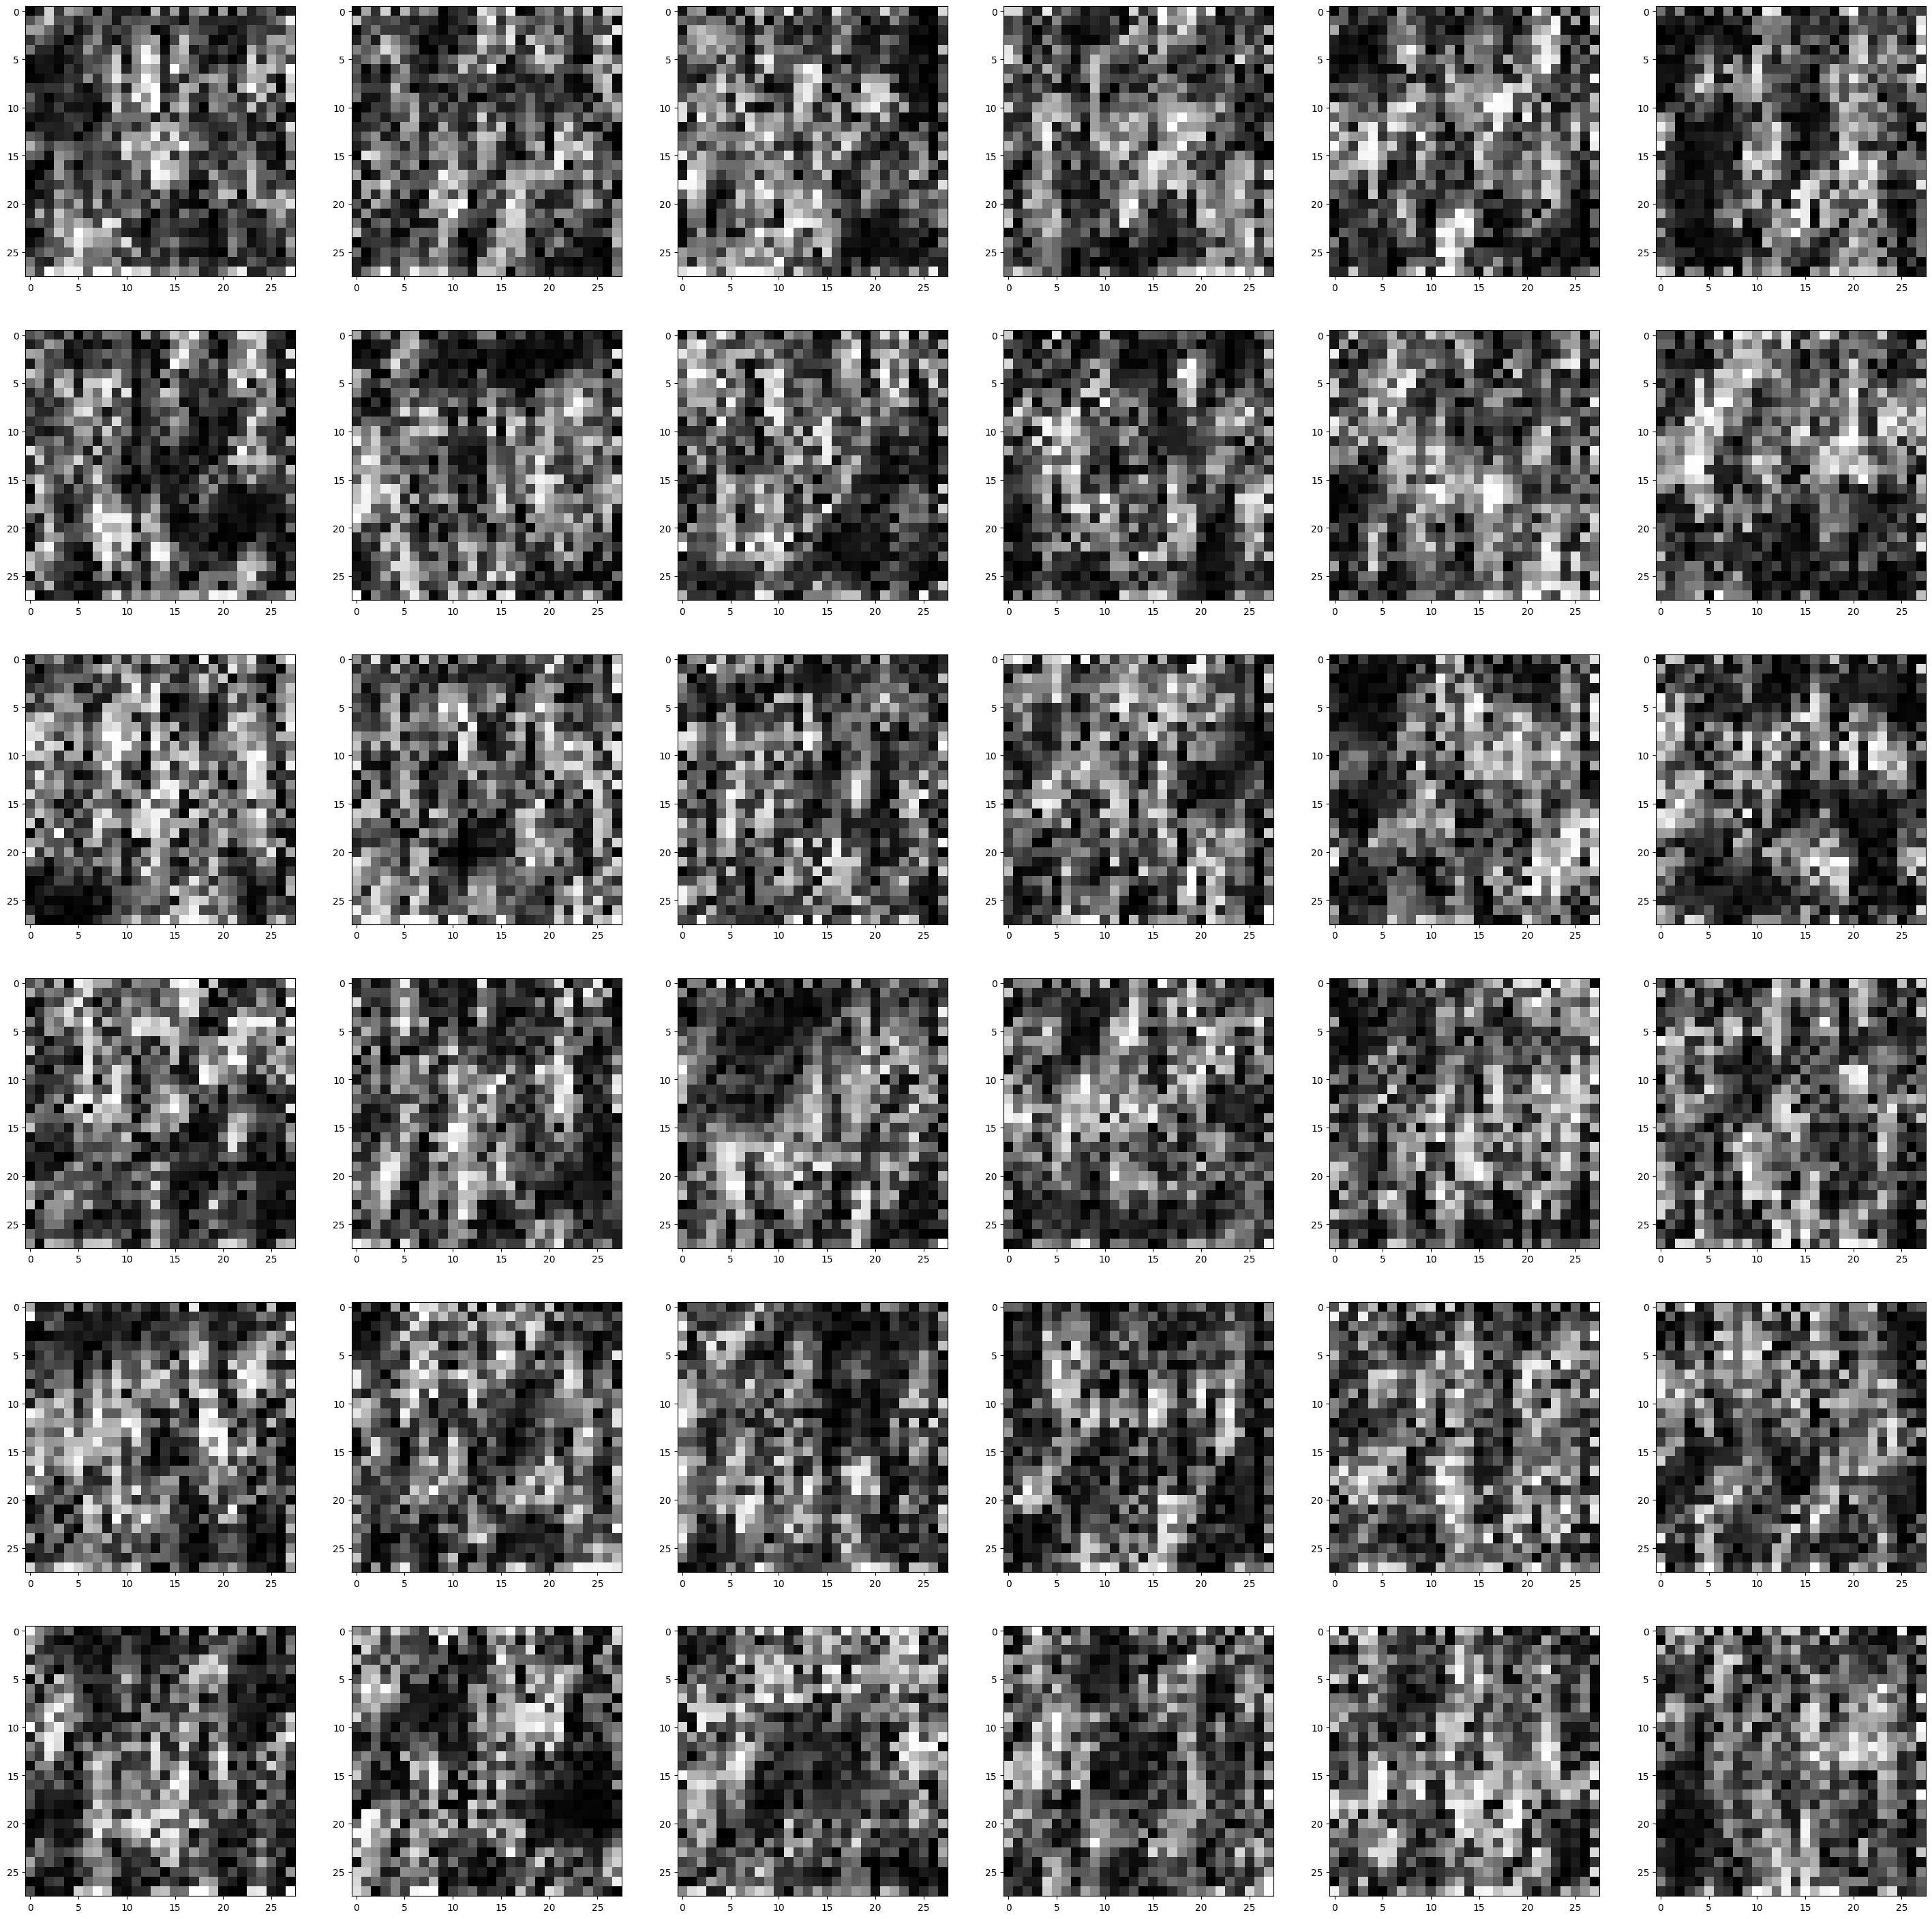

In [40]:
# Plotting code for your final samples 
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36,36)) 
for i in range(36): 
  ax[i//6][i%6].imshow(samples[-1][i][0], cmap='gray', interpolation='nearest') 
plt.savefig("./learned_diffusion_ones.pdf") 
plt.show() 

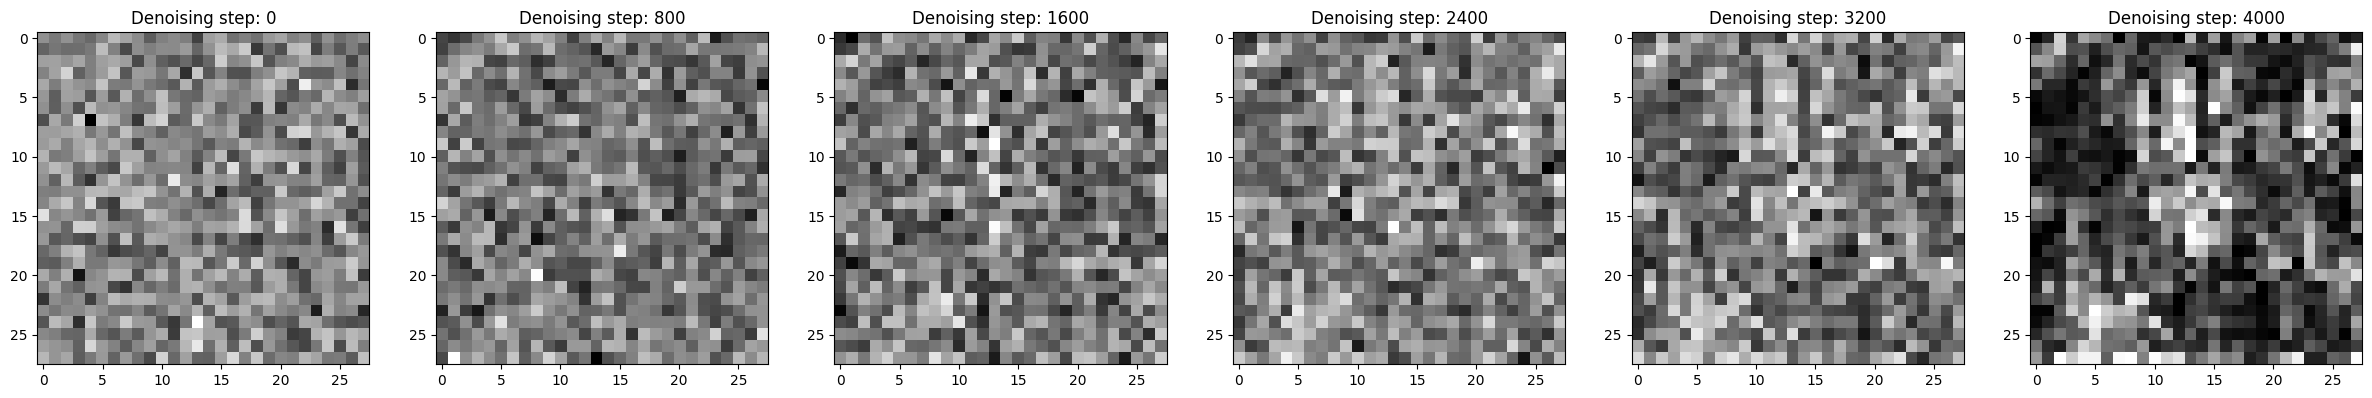

In [42]:
fig, ax = plt.subplots(ncols=6, figsize=(30,7)) 

subplot_idx = 0 
for i in range(timesteps):
    if i == 0 or (i+1) % (timesteps//5) == 0:
        ax[subplot_idx].imshow(samples[i][0][0], cmap='gray', interpolation='nearest')
        if i == 0:
          ax[subplot_idx].set_title("Denoising step: 0") 
        else: 
          ax[subplot_idx].set_title(f"Denoising step: {i+1}") 
        subplot_idx += 1 
plt.show() 